# Surface classification using 2-forms

In this notebook we show how to integrate $2$- forms in $\mathbb{R}^n$ over a $2$-simplex. A $2$-form $\omega \in\Omega^2(\mathbb{R}^n)$ can be written in coordinates as $\omega = \sum_{0\leq i < j \leq n} f_{i,j} dx_i\wedge dx_j$

In [28]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import math
import gudhi as gd 
import scipy.special

import k_forms as kf


[[0, 1, 5], [1, 2, 6], [1, 5, 6], [2, 3, 7], [2, 6, 7], [3, 4, 8], [3, 7, 8], [4, 8, 9], [5, 6, 10], [6, 7, 11], [6, 10, 11], [7, 8, 12], [7, 11, 12], [8, 9, 13], [8, 12, 13], [9, 13, 14], [10, 11, 15], [11, 12, 16], [11, 15, 16], [12, 13, 17], [12, 16, 17], [13, 14, 18], [13, 17, 18], [14, 18, 19], [15, 16, 20], [16, 17, 21], [16, 20, 21], [17, 18, 22], [17, 21, 22], [18, 19, 23], [18, 22, 23], [19, 23, 24]]


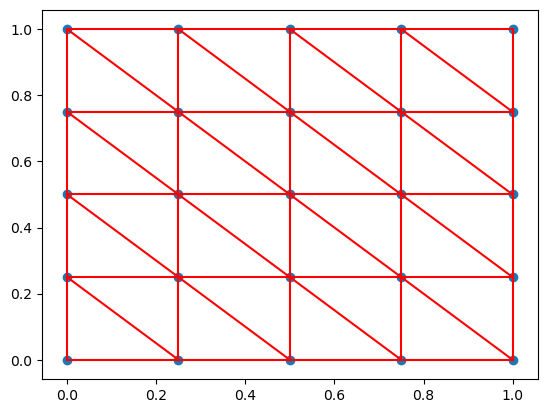

In [29]:
num_pts = 5 
pts , ac = kf.plot_unit_square_grid(num_pts)
simplices = []
for s in ac.get_skeleton(2):
    if len(s[0]) == 3: 
        simplices.append(s[0])

print(simplices)
    
    

In [30]:
# generate surface data
num_surf = 10
eps = 3
s0 = kf.generate_surfaces_yz(num_surf, num_pts , eps) ## the surfaces are a bit too regular, change a bit the generation code later
s1 = kf.generate_surfaces_xz(num_surf, num_pts , eps)
s2 = kf.generate_curved_surfaces(num_surf, num_pts , eps)
surfaces = s0 + s1 + s2

# generate labels
labels = np.concatenate((np.zeros(100),np.ones(100),2*np.ones(100)))

# perform a one hot encoding of the labels and transform to torch
labels_one_hot = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64))

## shuffle the data and the labels in the same way
shuffled_indices = torch.randperm(len(surfaces)) 
surfaces_shuffled = [surfaces[i] for i in shuffled_indices]
labels_one_hot_shuffled = labels_one_hot[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

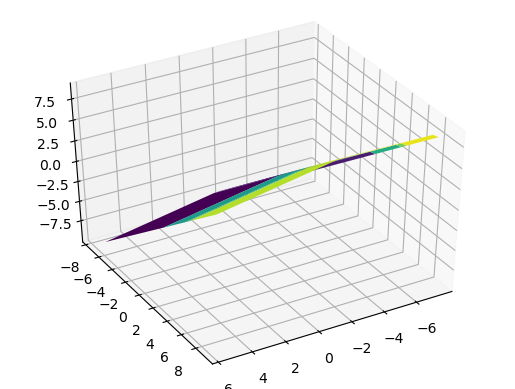

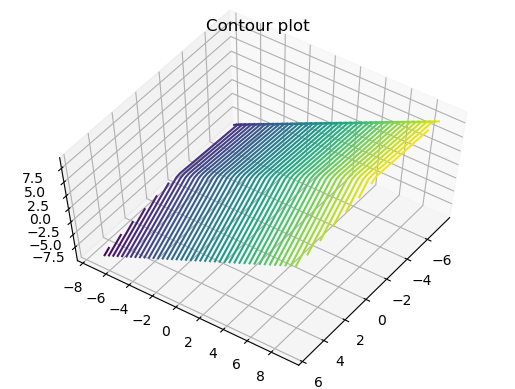

In [31]:
# plot one surface
kf.plot_surface(surfaces[5][0],surfaces[5][1],surfaces[5][2])

In [32]:
## make a simple model to classify the surfaces using one 2-form

# define the model 


In [33]:
k = 2 
dim = 3 
classes = 3
num_cochains = 1
N = int(scipy.special.binom(dim,k))

kform = nn.Sequential(
    nn.Linear(dim, N) ## can add layers here if needed
)

## Mlp layers post integration

mlp = nn.Sequential(
    nn.Linear(num_cochains, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, classes)
)

## for later: include the possibiliy of learning multiple k-forms

l = 2 # number of k-forms to use 

kforms = nn.Sequential(
    nn.Linear(dim, N*l)
)



In [34]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(kform.parameters(), lr=1e-2)

criterion = nn.CrossEntropyLoss()


In [81]:

def form2cochain(kform, phi, simplices, dim, num_sub): 
    cochain = torch.zeros(len(simplices))
    deter_tensor = build_big_deter_tensor(dim,2) ## maybe this computation can be done outside the function 
    for i in range(len(simplices)):
        simplex = simplices[i]
        phi_simplex = torch.zeros((len(simplex), dim))
        phi_simplex = phi[torch.tensor(simplex)]
        cochain[i] = kf.integral_simplex(kform, phi_simplex, deter_tensor, num_sub)

    return cochain

In [102]:
def form2cochain_output(kform, phi, simplices, dim, num_sub, mlp, classes = 3): 
    output = torch.zeros(len(simplices),classes)
    cochain = torch.zeros(len(simplices),1)
    deter_tensor = kf.build_big_deter_tensor(dim,2) ## maybe this computation can be done outside the function 
    
    for i in range(len(simplices)):
        simplex = simplices[i]
        phi_simplex = torch.zeros((len(simplex), dim))
        phi_simplex = phi[torch.tensor(simplex)]
        cochain[i] = kf.integral_simplex(kform, phi_simplex, deter_tensor, num_sub)

    #output = mlp(cochain)

    return cochain 


In [103]:
epochs = 2
dim = 3
num_sub = 5

losses = torch.zeros(epochs)

labels_one_hot_shuffled = labels_one_hot_shuffled.to(torch.float32)

torch.autograd.set_detect_anomaly(True)

for i in range(len(surfaces_shuffled)):
   _, _, _, phi_s = surfaces_shuffled[i]
   l = labels_one_hot_shuffled[i]
   X = form2cochain_output(kform, phi_s, simplices, dim, num_sub, mlp , 3)
   print(X.shape)
   X = mlp(X)
   #print(X)
   print(X.shape)
   X = X.sum(0)
   #print(X.shape)
   # softmax
   sm = torch.nn.functional.softmax(X)
   #print(sm)
   #loss = criterion(sm,l) 
   #print("loss: ", loss)
   print('********')
   loss.backward(retain_graph=True)
   optimizer.step()
   optimizer.zero_grad()



   
   
   

torch.Size([32, 1])
torch.Size([32, 3])
********


/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/torch/autograd/__init__.py:199: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  Fil

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
sm = torch.nn.functional.softmax(X)


    loss = criterion(sm,l.float())

    losses[i,j] = loss.detach()

    
    loss.backward()

    # for some reason it works better doing the backprop/gradient step after each path

    optimizer.step()

    optimizer.zero_grad()

    # clear print statement from previous iteration
    # clear_output(wait=True)
    
   